In [ ]:
val_dataset = tfds.load('cityscapes', split='validation')
val_dataset = val_dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(4).prefetch(tf.data.experimental.AUTOTUNE)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=1)])
for images, labels in val_dataset.take(1):
    print(f"Image shape: {images.shape}")
    print(f"Label shape: {labels.shape}")
    predictions = model.predict(images)
    print(f"Prediction shape: {predictions.shape}")

# Evaluate the model on the validation dataset
val_loss, val_accuracy, val_mean_iou = model.evaluate(val_dataset)
print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {val_accuracy}")
print(f"Validation Mean IoU: {val_mean_iou}")

Image shape: (4, 256, 256, 3)
Label shape: (4, 256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 56s 56s/step
Prediction shape: (4, 256, 256, 34)


2024-07-28 18:10:09.816741: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
import time
import tensorflow_datasets as tfds
import numpy as np

# Load the Cityscapes dataset
dataset, info = tfds.load('cityscapes', split='train', with_info=True)
val_dataset = tfds.load('cityscapes', split='validation')

# Define preprocessing functions

def preprocess_image(features):
    image = features['image_left']
    label = features['segmentation_label']
    image = tf.image.resize(image, (256, 512))
    label = tf.image.resize(label, (256, 512), method='nearest')
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.cast(label, tf.int32)
    return image, label
    

# Preprocess the dataset
dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.batch(2).prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(2).prefetch(tf.data.experimental.AUTOTUNE)

In [3]:
def count_labels(dataset):
    label_counts = {}
    for images, labels in dataset:
        unique_labels, counts = np.unique(labels.numpy(), return_counts=True)
        for label, count in zip(unique_labels, counts):
            if label in label_counts:
                label_counts[label] += count
            else:
                label_counts[label] = count
    return label_counts

# Count labels in the training dataset
train_label_counts = count_labels(dataset)
print("Training Dataset Label Counts:", train_label_counts)

# Count labels in the validation dataset
val_label_counts = count_labels(val_dataset)
print("Validation Dataset Label Counts:", val_label_counts)

print("Count Train Labels", len(train_label_counts))
print("Count Val Labels", len(val_label_counts))  

2024-07-29 14:41:02.024390: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training Dataset Label Counts: {1: 18191965, 3: 4557700, 4: 5245901, 6: 4736400, 7: 127429306, 8: 21061823, 11: 78980429, 13: 3036614, 17: 4244186, 19: 717988, 20: 1905014, 21: 55094626, 22: 4008030, 23: 13912632, 24: 4213048, 25: 466928, 26: 24200155, 33: 1431611, 0: 44893, 5: 1115676, 9: 2447190, 12: 2268602, 2: 5408748, 18: 31201, 32: 341334, 29: 156089, 28: 812723, 31: 805504, 27: 924887, 15: 1117817, 30: 81549, 10: 703788, 14: 34291, 16: 210552}
Validation Dataset Label Counts: {1: 3249610, 3: 766000, 4: 979373, 5: 278560, 7: 21600943, 8: 3106417, 9: 260080, 11: 12589806, 12: 421139, 13: 471394, 17: 848259, 18: 4963, 19: 113109, 20: 381930, 21: 9948505, 23: 1927788, 24: 745694, 25: 123569, 26: 3741620, 27: 172704, 28: 222849, 32: 45688, 33: 407327, 2: 1315242, 6: 1169616, 22: 477762, 0: 23623, 10: 40004, 31: 64473, 15: 19512, 29: 3348, 30: 12650, 14: 2443}


2024-07-29 14:41:20.470033: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
print(len(train_label_counts))
print(len(val_label_counts))  

34
33


In [1]:
# Define the U-Net model architecture
def unet(input_size=(256, 512, 3)):
    inputs = tf.keras.Input(input_size)
    
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    outputs = layers.Conv2D(34, (1, 1), activation='softmax')(c9)  # 34 classes in Cityscapes dataset
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Create the U-Net model
model = unet(input_size=(256, 512, 3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model and measure the time taken
start_time = time.time()
history = model.fit(dataset, epochs=1, validation_data=val_dataset)
end_time = time.time()

# Print the time taken to train the model
print(f"Time taken to train the model: {end_time - start_time:.2f} seconds")


2024-07-29 14:21:26.237596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 14:21:26.906034: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 14:21:27.022058: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-29 14:21:27.805239: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-29 14:21:36.914267: W tensorflow/compiler/tf2

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 512,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 512,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 256,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 256,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 128,   │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 128,   │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 128,   │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 64,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 64,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 32,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 32,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 32,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 64,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 64,    │          0 │ conv2d_transpose

 Total params: 31,033,890 (118.38 MB)

 Trainable params: 31,033,890 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

I0000 00:00:1722255732.630483   17452 service.cc:146] XLA service 0x7f33680286f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722255732.630591   17452 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti, Compute Capability 6.1
2024-07-29 14:23:00.694610: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1722255781.877822   17452 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-07-29 14:23:02.868986: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-07-29 14:23:27.538386: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.30GiB with freed_by_count=0. The caller indicates that this

1487/1488 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.5053 - loss: 1.8234

W0000 00:00:1722256592.534008   17451 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-07-29 14:36:43.584229: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1488/1488 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.5054 - loss: 1.8231

W0000 00:00:1722256631.407068   17449 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-07-29 14:37:16.664611: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-29 14:37:20.869877: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng13{} for conv (f32[2,128,128,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,128,128,256]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode"

1488/1488 ━━━━━━━━━━━━━━━━━━━━ 987s 587ms/step - accuracy: 0.5055 - loss: 1.8227 - val_accuracy: 0.7245 - val_loss: 0.9500
Time taken to train the model: 988.51 seconds


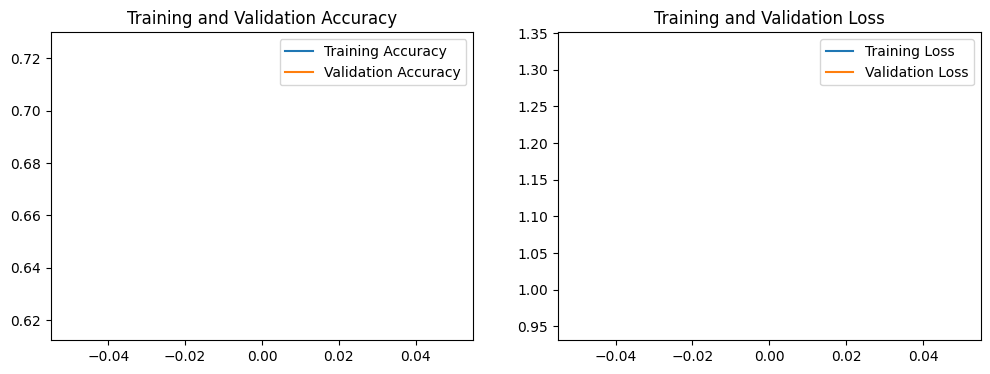

In [2]:
import matplotlib.pyplot as plt

# Get training and validation metrics from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [12]:
test_dataset = tfds.load('cityscapes', split='test')

# Preprocess the dataset
test_dataset = test_dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1).prefetch(tf.data.experimental.AUTOTUNE)

for example in test_dataset.take(1):
    print(example)



(<tf.Tensor: shape=(1, 256, 512, 3), dtype=float32, numpy=
array([[[[0.2509804 , 0.39019608, 0.42156863],
         [0.2754902 , 0.3882353 , 0.4019608 ],
         [0.28921568, 0.40588236, 0.42058823],
         ...,
         [0.73333335, 0.90686274, 0.9558824 ],
         [0.73137254, 0.90294117, 0.9519608 ],
         [0.7323529 , 0.90588236, 0.94509804]],

        [[0.20196079, 0.30686274, 0.327451  ],
         [0.28039217, 0.38431373, 0.3970588 ],
         [0.29215688, 0.4107843 , 0.422549  ],
         ...,
         [0.7372549 , 0.9098039 , 0.9519608 ],
         [0.73137254, 0.904902  , 0.9519608 ],
         [0.72843134, 0.90588236, 0.9529412 ]],

        [[0.18333334, 0.26078433, 0.29509804],
         [0.2784314 , 0.38333333, 0.39411765],
         [0.28921568, 0.40784314, 0.41862744],
         ...,
         [0.7323529 , 0.904902  , 0.95392156],
         [0.72745097, 0.90686274, 0.9490196 ],
         [0.73137254, 0.90686274, 0.9431372 ]],

        ...,

        [[0.15686275, 0.21862745,

2024-07-29 14:51:54.434201: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [22]:
tf.keras.backend.clear_session()

dummy_batch = next(iter(test_dataset))
dummy_image = dummy_batch[0]
model.predict(dummy_image, verbose=0)  # Warm-up the model

total_time=0

for i in range(5):
    start_time = time.time()

    for batch in test_dataset:
        image = batch[0]
        predictions = model.predict(image, verbose=0)

    end_time = time.time()
    print("run", i+1)
    print(f"Inference Time: {end_time - start_time:.2f} seconds")
    print(f"Number of Images: {len(test_dataset)}")
    print(f"Average Inference Time per Image: {(end_time - start_time)/len(test_dataset)*1000:.0f}ms")
    print("----------------")
    total_time += end_time - start_time

print(f"Average Inference Time: {(end_time - start_time)/5:.2f} seconds")
print(f"Number of Images: {len(test_dataset)}")
print(f"Average Inference Time per Image: {total_time/5/len(test_dataset)*1000:.0f}ms")

run 0
Inference Time: 286.74 seconds
Number of Images: 1525
Average Inference Time per Image: 188ms
----------------


2024-07-29 15:36:45.661923: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


run 1
Inference Time: 347.93 seconds
Number of Images: 1525
Average Inference Time per Image: 228ms
----------------


KeyboardInterrupt: 

In [ ]:
tf.keras.backend.clear_session()
all_predictions = []

for batch in test_dataset:
    image = batch[0]
    predictions = model.predict(image)
    all_predictions.append(predicted_classes)



for images, labels in val_dataset.take(1):
    print(f"Image shape: {images.shape}")
    print(f"Label shape: {labels.shape}")
    print(f"Prediction shape: {all_predictions[0].shape}")

# `predictions` shape: (batch_size, 512, 256, 34)

# To get the predicted class for each pixel, use argmax along the channel axis
predicted_classes = np.argmax(predictions, axis=-1)

# `predicted_classes` shape: (batch_size, 512, 256)
print(f"Prediction shape: {predicted_classes.shape}")